# Intrusion Detection Evaluation Dataset (CIC-IDS2017)
By AliK604 

Intrusion Detection Systems (IDSs) and Intrusion Prevention Systems (IPSs) are the most important defense tools against the sophisticated and ever-growing network attacks. Due to the lack of reliable test and validation datasets, anomaly-based intrusion detection approaches are suffering from consistent and accurate performance evolutions.

In [7]:
!conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.3
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.



In [1]:
# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost, lightgbm
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
ls = [] 
directory = (r'./MachineLearningCVE/')
for filename in os.listdir(r'./MachineLearningCVE/'):
  if '.csv' in  filename:
    print(filename)
    full_path = os.path.join(directory, filename)
    df = pd.read_csv(full_path)
    ls.append(df)
    print(f'Shape: {df.shape}. Attack Type {df[" Label"].unique()}')
    # break

Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Shape: (288602, 79). Attack Type ['BENIGN' 'Infiltration']
Monday-WorkingHours.pcap_ISCX.csv
Shape: (529918, 79). Attack Type ['BENIGN']
Friday-WorkingHours-Morning.pcap_ISCX.csv
Shape: (191033, 79). Attack Type ['BENIGN' 'Bot']
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Shape: (286467, 79). Attack Type ['BENIGN' 'PortScan']
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Shape: (225745, 79). Attack Type ['BENIGN' 'DDoS']
Tuesday-WorkingHours.pcap_ISCX.csv
Shape: (445909, 79). Attack Type ['BENIGN' 'FTP-Patator' 'SSH-Patator']
Wednesday-workingHours.pcap_ISCX.csv
Shape: (692703, 79). Attack Type ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Shape: (170366, 79). Attack Type ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']


In [3]:
for df in ls:
  cols = df.columns.to_list()
  for i in range(len(cols)):
    cols[i] = cols[i].strip()
  df.columns = cols

In [4]:
df = pd.concat(ls)
df.head(3)
assert df.shape[1] == 79

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
# mix of ints and floats. Label is a object (words)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    # df.dtypes


In [6]:
from collections import Counter

Counter(df["Label"])

Counter({'BENIGN': 2273097,
         'Infiltration': 36,
         'Bot': 1966,
         'PortScan': 158930,
         'DDoS': 128027,
         'FTP-Patator': 7938,
         'SSH-Patator': 5897,
         'DoS slowloris': 5796,
         'DoS Slowhttptest': 5499,
         'DoS Hulk': 231073,
         'DoS GoldenEye': 10293,
         'Heartbleed': 11,
         'Web Attack � Brute Force': 1507,
         'Web Attack � XSS': 652,
         'Web Attack � Sql Injection': 21})

In [7]:
print(f'df.shape {df.shape} before sampling out most of benign data')
df = pd.concat([df[df['Label'] != 'BENIGN'], df[df['Label'] == 'BENIGN'].sample(frac=.1, random_state=42)]) # 20% of total is Malicious; Use only a sample of the BENIGN data
print(f'df.shape {df.shape} after sampling out most of benign data')

df.shape (2830743, 79) before sampling out most of benign data
df.shape (784956, 79) after sampling out most of benign data


In [8]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df.head(3)
le.classes_

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
66383,444,42664070,5,6,141,291,93,0,28.200000,38.861292,...,20,0.0,0.0000,0,0,0.0,0.000,0,0,9
68410,444,2030,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0000,0,0,0.0,0.000,0,0,9
72581,444,119991834,5523,5525,2866110,33406,1274,0,518.940793,204.203530,...,20,997842.0,831471.3076,1585781,409903,8143987.5,1821773.648,9432176,6855799,9


array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator',
       'Web Attack � Brute Force', 'Web Attack � Sql Injection',
       'Web Attack � XSS'], dtype=object)

In [13]:
lowSTD = list(df.std().to_frame().nsmallest(20, columns=0).index)
df[lowSTD].head(3)

,Bwd PSH Flags,Bwd URG Flags,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,RST Flag Count,ECE Flag Count,Fwd URG Flags,CWE Flag Count,Label,FIN Flag Count,Fwd PSH Flags,SYN Flag Count,URG Flag Count,ACK Flag Count,PSH Flag Count,Down/Up Ratio
66383,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
68410,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
72581,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1


In [14]:
lowCORR = list(df.corr().abs().sort_values('Label')['Label'].nsmallest(20).index) # .where(lambda x: x < 0.005).dropna()
df[lowCORR].head(3)

,Down/Up Ratio,ECE Flag Count,RST Flag Count,Total Length of Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_backward,Fwd URG Flags,CWE Flag Count,Flow IAT Min,Flow Bytes/s,Bwd IAT Min,Packet Length Variance,FIN Flag Count,Fwd IAT Min,Bwd IAT Mean,URG Flag Count,Bwd Packets/s,Init_Win_bytes_forward,Fwd IAT Mean,Fwd Packets/s
66383,1,0,0,291,291,229,0,0,29,10.125616,595,5990.727273,0,609,8.532630e+06,0,0.140634,8192,63977.00000,0.117195
68410,0,0,0,0,0,-1,0,0,2030,5911.330049,0,0.000000,0,2030,0.000000e+00,0,0.000000,255,2030.00000,985.221675
72581,1,0,0,33406,33406,3294,0,0,3,24164.277710,582,86619.573440,0,493,2.172175e+04,0,46.044800,8192,21729.77798,46.028132


In [15]:
print(f'Intersection: {set(lowSTD).intersection(set(lowCORR))}')
print(f'Union:        {len(set(lowSTD).union(set(lowCORR)))}')

Intersection: {'Down/Up Ratio', 'URG Flag Count', 'ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'CWE Flag Count', 'FIN Flag Count'}
Union:        33


In [9]:
import gc 
gc.collect()

0

In [10]:
df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN

df = df.fillna(df.mean())
df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])
df = df.loc[:, (df != df.iloc[0]).any()]

indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df = df[indices_to_keep]


for i in df.columns:
    df = df[df[i] != "Infinity"]
    df = df[df[i] != np.nan]
    df = df[df[i] != np.inf]
    df = df[df[i] != -np.inf]
    df = df[df[i] != ",,"]
    df = df[df[i] != ", ,"]
    
print(np.any(np.isnan(df)))
print(np.any(np.isfinite(df)))
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Last column turn to binary
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 1 if x != 0 else 0).astype(int)


X_train, X_test, y_train, y_test = train_test_split(df.drop(['Label'],axis=1), df['Label'], test_size=.20, random_state=42)


False
True


In [11]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

In [12]:
X_train
y_train.tail(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
89345,80,9617768,5,0,30,0,6,6,6.000000,0.000000,...,4,20,1021.0,0.0,1021,1021,9616747.0,0.0,9616747,9616747
98402,5922,42,1,1,2,6,2,2,2.000000,0.000000,...,0,24,0.0,0.0,0,0,0.0,0.0,0,0
135689,80,35240,3,6,26,11601,20,0,8.666667,10.263203,...,2,20,0.0,0.0,0,0,0.0,0.0,0,0
66973,80,80186176,9,6,62,11601,20,0,6.888889,5.301991,...,7,20,1930.0,0.0,1930,1930,39200000.0,41600000.0,68600000,9801105
117291,80,426370,3,5,26,11607,20,0,8.666667,10.263203,...,2,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151943,80,98937887,8,5,56,11601,20,0,7.000000,5.656854,...,6,20,1107383.0,0.0,1107383,1107383,96700000.0,0.0,96700000,96700000
129292,80,98130962,7,4,351,11595,351,0,50.142857,132.665530,...,1,32,986.0,0.0,986,986,98100000.0,0.0,98100000,98100000
221614,143,46,1,1,0,6,0,0,0.000000,0.000000,...,0,40,0.0,0.0,0,0,0.0,0.0,0,0
203495,53,182,2,2,60,264,30,30,30.000000,0.000000,...,1,32,0.0,0.0,0,0,0.0,0.0,0,0


151943    1
129292    1
221614    1
203495    0
210719    1
Name: Label, dtype: int64

In [25]:
def benchmark(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
  GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 50)
  clfs = [GBM]
  for clf in clfs:
      _ = clf.fit(X_train, y_train)
      pred = clf.score(X_test, y_test)
      name = str(type(clf)).split(".")[-1][:-2]
      print("Acc: %0.5f for the %s" % (pred, name))
  return clfs

# Accuracy Evaluation

In [28]:
print('Baseline with all features')
clfs = benchmark()

Baseline with all features


[LightGBM] [Fatal] Number of classes must be 1 for non-multiclass training


LightGBMError: Number of classes must be 1 for non-multiclass training

In [16]:
print('Solely with features identified as useless')

GBM = clfs[0]
remove = X_train.columns.to_numpy()[GBM.feature_importances_ == 0] 
clfs = benchmark(X_train[remove], X_test[remove])
print(remove)

Solely with features identified as useless
Acc: 0.95991 for the LGBMClassifier
['Bwd PSH Flags' 'Bwd URG Flags' 'SYN Flag Count' 'RST Flag Count'
 'CWE Flag Count' 'ECE Flag Count' 'Avg Fwd Segment Size'
 'Avg Bwd Segment Size' 'Fwd Header Length.1' 'Fwd Avg Bytes/Bulk'
 'Fwd Avg Packets/Bulk' 'Fwd Avg Bulk Rate' 'Bwd Avg Bytes/Bulk'
 'Bwd Avg Packets/Bulk' 'Bwd Avg Bulk Rate' 'Subflow Fwd Packets'
 'Subflow Fwd Bytes' 'Subflow Bwd Packets' 'Subflow Bwd Bytes']


In [17]:
print('Solely with features identified as useful')
clfs = benchmark(X_train.drop(remove,1), X_test.drop(remove,1))

Solely with features identified as useful
Acc: 0.96422 for the LGBMClassifier


In [18]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

print('PCA 5')
pca = PCA(5)
_ = benchmark(pca.fit_transform(X_train), pca.transform(X_test))

PCA 5
Acc: 0.92331 for the LGBMClassifier


In [19]:
print('PCA 15')
pca = PCA(15)
_ = benchmark(pca.fit_transform(X_train), pca.transform(X_test))

PCA 15
Acc: 0.95175 for the LGBMClassifier


In [20]:
print('PCA 25')
pca = PCA(25)
_ = benchmark(pca.fit_transform(X_train), pca.transform(X_test))

PCA 25
Acc: 0.96008 for the LGBMClassifier


In [21]:
tmp = np.argsort(GBM.feature_importances_)
tmp = tmp[::-1] # large to small 
top = tmp[:20] # index of the top N
rest = tmp[20:]
print(GBM.feature_importances_[top]) # check 

[1715 1540 1300 1250 1109  940  767  721  667  608  550  530  505  449
  406  403  387  362  345  338]


In [22]:
print('Top 20 features (per `LGBMClassifier`) + PCA(15) of remaining') # 2nd highest 
pca = PCA(15)

a = pd.concat([X_train.iloc[:, top], pd.DataFrame(pca.fit_transform(X_train.iloc[:, rest]))], axis=1, ignore_index=True) 
b = pd.concat([X_test.iloc[:, top] , pd.DataFrame(pca.transform    (X_test.iloc[:, rest])) ], axis=1, ignore_index=True) 

_ = benchmark(a, b)

Top 20 features (per `LGBMClassifier`) + PCA(15) of remaining
Acc: 0.98277 for the LGBMClassifier


# Conclusion 

**Baseline with all features**
* Acc: 0.98591 for the LGBMClassifier

Solely with features identified as useless
* Acc: 0.95991 for the LGBMClassifier

Solely with features identified as useful
* Acc: 0.96422 for the LGBMClassifier

PCA 5
* Acc: 0.92331 for the LGBMClassifier

PCA 15
* Acc: 0.94629 for the LGBMClassifier

PCA 25
* Acc: 0.94210 for the LGBMClassifier

**Top 20 features (per `LGBMClassifier`) + PCA(15) of remaining**
* Acc: 0.98277 for the LGBMClassifier

# SHAP

In [13]:
X_train

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
89345,80,9617768,5,0,30,0,6,6,6.000000,0.000000,...,4,20,1021.0,0.0,1021,1021,9616747.0,0.0,9616747,9616747
98402,5922,42,1,1,2,6,2,2,2.000000,0.000000,...,0,24,0.0,0.0,0,0,0.0,0.0,0,0
135689,80,35240,3,6,26,11601,20,0,8.666667,10.263203,...,2,20,0.0,0.0,0,0,0.0,0.0,0,0
66973,80,80186176,9,6,62,11601,20,0,6.888889,5.301991,...,7,20,1930.0,0.0,1930,1930,39200000.0,41600000.0,68600000,9801105
117291,80,426370,3,5,26,11607,20,0,8.666667,10.263203,...,2,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151943,80,98937887,8,5,56,11601,20,0,7.000000,5.656854,...,6,20,1107383.0,0.0,1107383,1107383,96700000.0,0.0,96700000,96700000
129292,80,98130962,7,4,351,11595,351,0,50.142857,132.665530,...,1,32,986.0,0.0,986,986,98100000.0,0.0,98100000,98100000
221614,143,46,1,1,0,6,0,0,0.000000,0.000000,...,0,40,0.0,0.0,0,0,0.0,0.0,0,0
203495,53,182,2,2,60,264,30,30,30.000000,0.000000,...,1,32,0.0,0.0,0,0,0.0,0.0,0,0


In [20]:
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 50)
_ = model.fit(X_train, y_train)
model_outputs = model.predict(X_train)

pred = model.score(X_test, y_test)
name = str(type(model)).split(".")[-1][:-2]
print("Acc: %0.5f for the %s" % (pred, name))



Acc: 0.99950 for the XGBClassifier


(627964, 70)

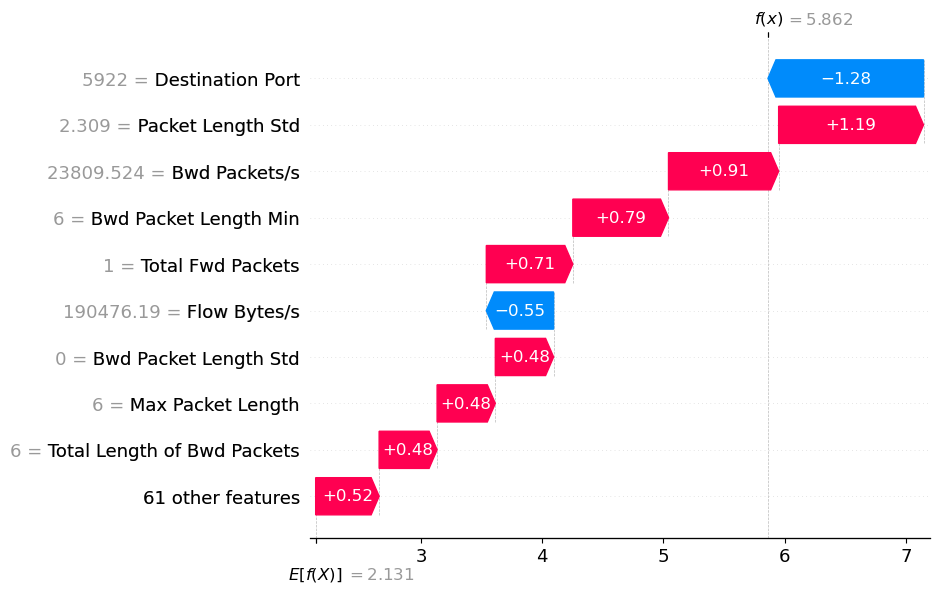

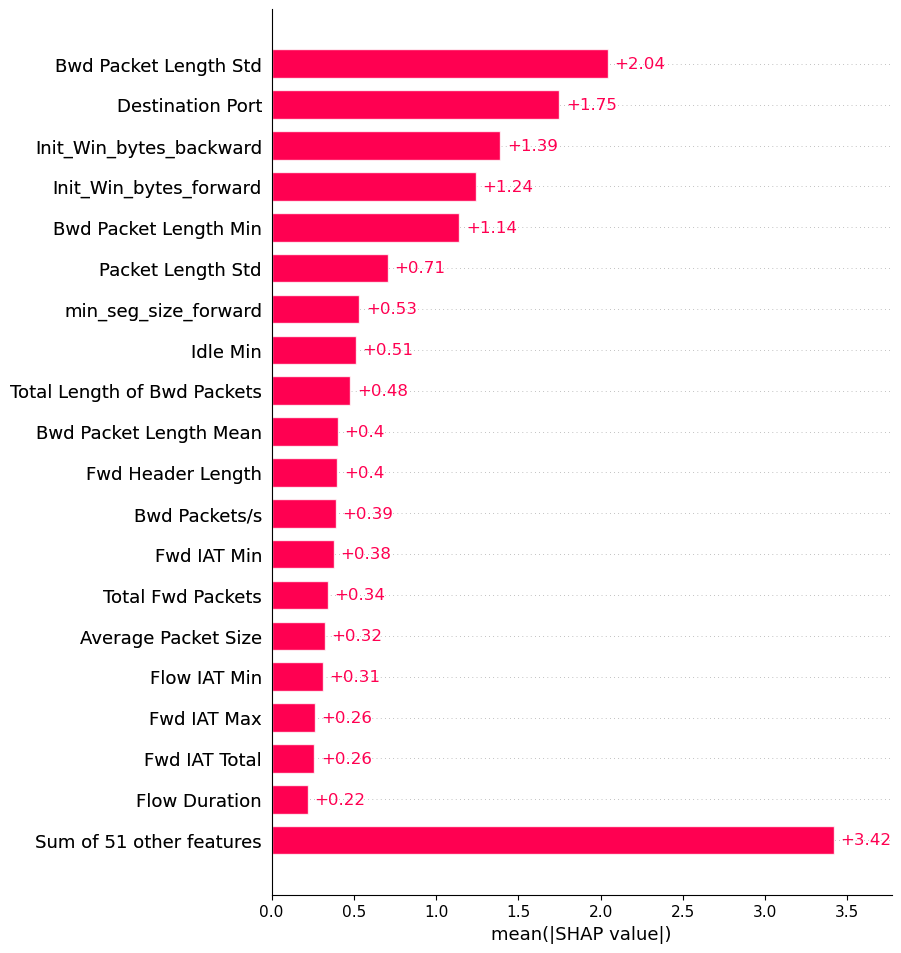

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


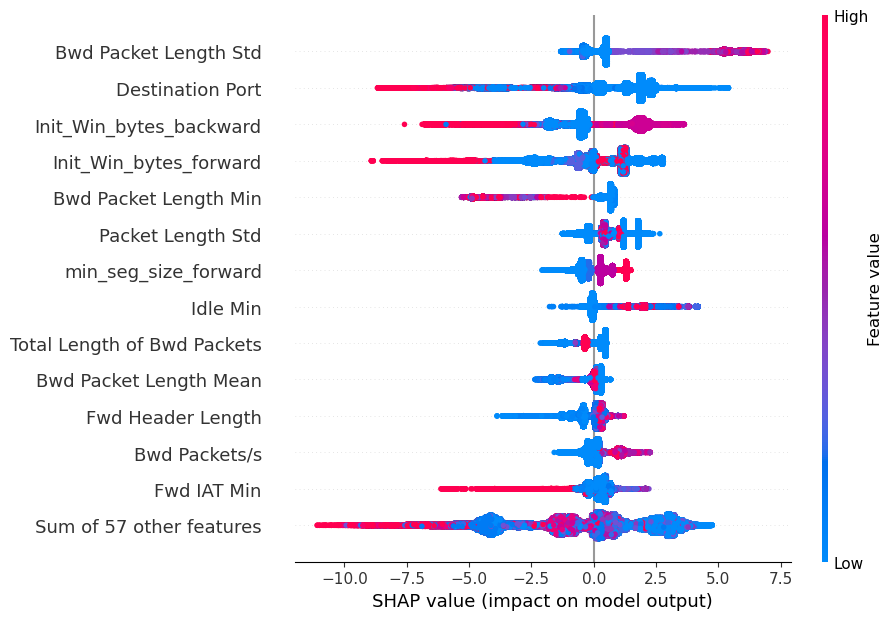

In [21]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
np.shape(shap_values.values)
shap.plots.waterfall(shap_values[1])
plt.show()
shap.plots.bar(shap_values, max_display=20, )
plt.show()

shap.plots.beeswarm(shap_values, max_display=14)
plt.show()

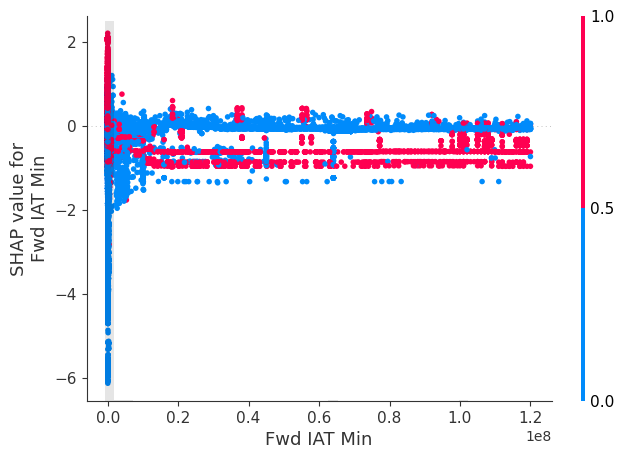

In [26]:
# shap.plots.scatter(shap_values[:,'Destination Port'], color=shap_values[:,'Label'])
shap.plots.scatter(shap_values[:,'Fwd IAT Min'], color=model_outputs)
plt.show()